Ensure similar amount data in each class

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/MSCI-446-Dataset/MSCI-446-Dataset"
data_path = path + "/Photos"

data2 = "/content/drive/MyDrive/Mechatronics"

#os.listdir(path)

count = {}
id_to_classname = {}
for i, class_name in enumerate(os.listdir(data_path)):
  count[class_name] = 0
  id_to_classname[i] = class_name
  for photo in os.listdir(data_path + '/' + class_name):
    count[class_name] = count[class_name] + 1

print(count)


Mounted at /content/drive
{'FreshGuava': 797, 'FreshBanana': 740, 'FreshGrape': 800, 'FreshJujube': 793, 'FreshApple': 734, 'RottenApple': 738, 'FreshStrawberry': 737, 'FreshPomegranate': 797, 'RottenBanana': 736, 'FreshOrange': 796, 'RottenPomegranate': 798, 'RottenGrape': 746, 'RottenJujube': 793, 'RottenOrange': 796, 'RottenGuava': 797, 'RottenStrawberry': 737}


Check if colab is connected to a GPU

In [ ]:
import tensorflow as tf
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  print("Colab is not connected to GPU")
else:
  print('Colab is connected to GPU')

Colab is connected to GPU


Import Data

In [ ]:
import tensorflow as tf

data = tf.keras.utils.image_dataset_from_directory(data_path)

Found 12335 files belonging to 16 classes.


Convert Data to 227 by 227 by 3 for AlexNet. Also standarize the images having the mean value be 0 and standard deviation of 1

In [ ]:
def preprocess(img, label):
  return tf.image.per_image_standardization(tf.image.resize(img, (227,227))), label

data = data.map(preprocess)

VGG-16 Model Implementation

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input

model_structure = []

#1st Convolutional block
model_structure.append(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same", input_shape=(227, 227, 3)))
model_structure.append(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same"))
model_structure.append(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#2nd Convolutional block
model_structure.append(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding="same"))
model_structure.append(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding="same"))
model_structure.append(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#3rd Convolutional block
model_structure.append(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding="same"))
model_structure.append(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding="same"))
model_structure.append(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding="same"))
model_structure.append(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#4th Convolutional block
model_structure.append(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding="same"))
model_structure.append(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding="same"))
model_structure.append(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding="same"))
model_structure.append(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#5th Convolutional block
model_structure.append(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding="same"))
model_structure.append(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding="same"))
model_structure.append(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding="same"))
model_structure.append(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#1st Fully connected layer
model_structure.append(Flatten())
model_structure.append(Dense(4096, activation='relu'))

#2nd Fully connected layer
model_structure.append(Dense(4096, activation='relu'))

#Output layer
model_structure.append(Dense(16, activation='softmax'))

model = Sequential(model_structure)

Split data into test, verification and training

In [ ]:
train_data = data.take(int(len(data)*.7))
val_data = data.take(int(len(data)*.2))
test_data = data.take(int(len(data)*.1))

Use SDG with momentum (well known for images as it generalizes well) with nesterov to reduce the potential for overshooting

In [ ]:
from tensorflow.keras.optimizers.experimental import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

model.compile(loss=SparseCategoricalCrossentropy(), optimizer=sgd, metrics=["accuracy"])

View Model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 227, 227, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 227, 227, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 113, 113, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 113, 113, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

Run Model

In [ ]:
result = model.fit(train_data, epochs=10, validation_data=val_data, shuffle=True)

model.save(path + '/vgg16_sgd.h5')

Epoch 1/10
270/270 [==============================] - 785s 3s/step - loss: 2.7256 - accuracy: 0.0922 - val_loss: 2.7783 - val_accuracy: 0.0519
Epoch 2/10
270/270 [==============================] - 141s 519ms/step - loss: 2.6580 - accuracy: 0.1128 - val_loss: 2.7919 - val_accuracy: 0.0584
Epoch 3/10
270/270 [==============================] - 140s 514ms/step - loss: 2.7766 - accuracy: 0.0649 - val_loss: 2.7744 - val_accuracy: 0.0519
Epoch 4/10
270/270 [==============================] - 140s 516ms/step - loss: 2.7743 - accuracy: 0.0583 - val_loss: 2.7733 - val_accuracy: 0.0519
Epoch 5/10
270/270 [==============================] - 134s 493ms/step - loss: 2.7740 - accuracy: 0.0627 - val_loss: 2.7737 - val_accuracy: 0.0524
Epoch 6/10
270/270 [==============================] - 140s 514ms/step - loss: 2.7738 - accuracy: 0.0611 - val_loss: 2.7728 - val_accuracy: 0.0511
Epoch 7/10
270/270 [==============================] - 141s 518ms/step - loss: 2.4960 - accuracy: 0.1512 - val_loss: 2.1354 - va

Extract data from result

In [ ]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']
loss = result.history['loss']
val_loss = result.history['val_loss']

Loss plot comparing validation and training data on each epoch

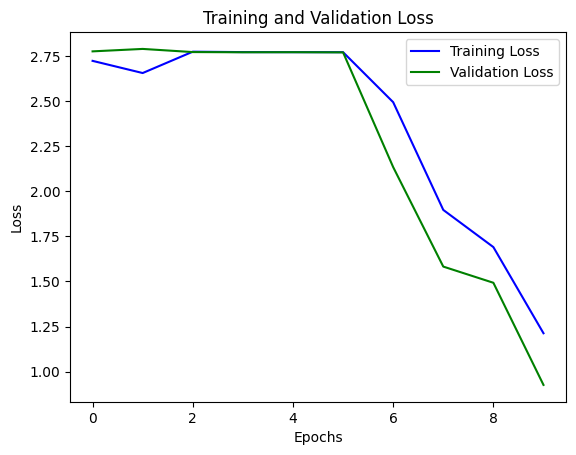

In [ ]:
import matplotlib.pyplot as plt

plt.plot(result.epoch, loss, 'b', label='Training Loss')
plt.plot(result.epoch, val_loss, 'g', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig(path + "/Training and Validation Loss")


plt.show()

Accuarcy plot comparing validation and training data on each epoch

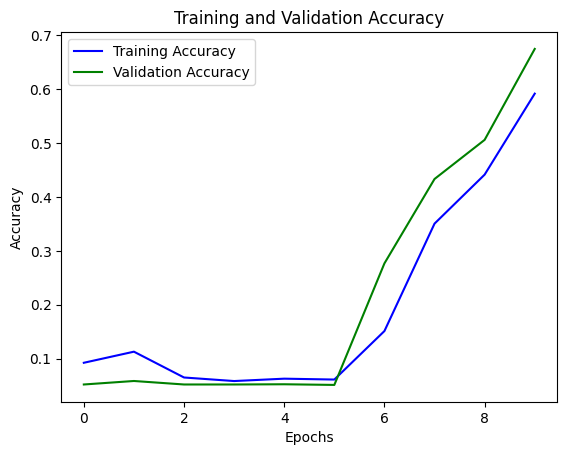

In [ ]:
import matplotlib.pyplot as plt

plt.plot(result.epoch, acc, 'b', label='Training Accuracy')
plt.plot(result.epoch, val_acc, 'g', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig(path + "/Training and Validation Accuracy")

plt.show()

Run test data on model

In [ ]:
result_test = model.evaluate(test_data)
print("The loss is ", result_test[0], " the accuracy is ", result_test[1])

38/38 [==============================] - 9s 202ms/step - loss: 0.9314 - accuracy: 0.6628
The loss is  0.9314048290252686  the accuracy is  0.6628289222717285


Confusion matrix of test data

In [ ]:
predictions = model.predict(test_data)

38/38 [==============================] - 10s 222ms/step


1/1 [==============================] - 0s 38ms/step


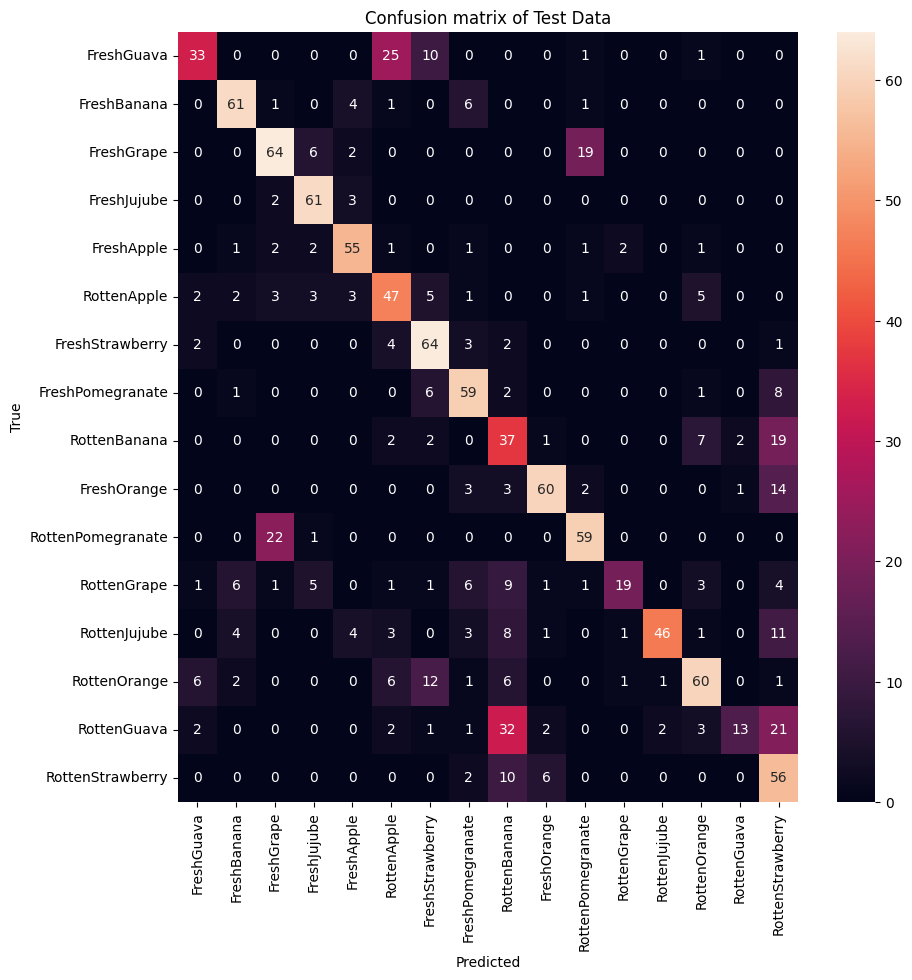

In [ ]:
import numpy as np
import seaborn as sns

predictions = np.array([])
labels =  np.array([])
for x, y in test_data.as_numpy_iterator():
  predictions = np.concatenate([predictions, tf.argmax(model.predict(x), axis=-1)])
  labels = np.concatenate([labels, y])

class_order = []
for name in os.listdir(data_path):
  class_order.append(name)

confusion_matrix = tf.math.confusion_matrix(labels=labels, predictions=predictions)

plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix, annot=True, xticklabels=class_order, yticklabels=class_order)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix of Test Data')
plt.savefig(path + "/Confusion matrix of Test Data")

plt.show()
